In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain # need this for plots below
import esg_loader as loader

%matplotlib inline

# load the dataframe

In [3]:
# load the metadata file
esg = loader.load_metadata('../data/esg_metadata.csv', '../data/ESG_wdi.feather')

# create some arrays of key display and logic fields
expl_a_g = list(map(lambda x: 'expl_'+x, list('abcdefg')))
expl_c_g = list(map(lambda x: 'expl_'+x, list('cdefg')))
explans = ['no_gap']+expl_a_g
core_fields = ['sector','cetsid','input_name']+explans


In [5]:
# New column that divides sources into WBG and all other external
esg['domain'] = np.where(esg['source_type']!='WBG','EXTERNAL',esg['source_type'])

# Dataframe of just the wbg dataset
wbg = esg[esg['wbgv1']==1]

In [6]:
# Summarize by type and sector
esg.pivot_table(index='source_type',columns='sector', aggfunc='count',values='cetsid',margins=True).reindex(['WBG', 'UN', 'OTHER', 'All'],axis=0).reindex(['ENV', 'SOC', 'GOV','All'], axis=1)


sector,ENV,SOC,GOV,All
source_type,,,,
WBG,10,12,14,36
UN,9,49,8,66
OTHER,25,5,2,32
All,44,66,24,134


In [7]:
# create a summary table in percentage terms
pt = esg.pivot_table(index='domain',columns='sector', aggfunc='count',values='cetsid')
pt['Total'] = pt.sum(axis=1)
pt

work = pt.copy()
for i in pt.columns:
    work[i] = pt[i] / pt[i].sum()

work.loc['Total'] = pt.sum() / pt.sum()['Total']
work

sector,ENV,GOV,SOC,Total
domain,,,,
EXTERNAL,0.772727,0.416667,0.818182,0.731343
WBG,0.227273,0.583333,0.181818,0.268657
Total,0.328358,0.179104,0.492537,1.000000


In [8]:
# here is the percent composition of both datasets
p = pd.DataFrame({'TOTAL': esg[explans].sum(), 'WBGV1': wbg[explans].sum()})
p['TOTAL_PERC'] = p['TOTAL'] * 100 / len(esg)
p['WBGV1_PERC'] = p['WBGV1'] * 100 / len(wbg)
p.sort_index(axis=1)

,TOTAL,TOTAL_PERC,WBGV1,WBGV1_PERC
no_gap,12,8.955224,10,14.925373
expl_a,15,11.194030,0,0.000000
expl_b,15,11.194030,6,8.955224
expl_c,66,49.253731,37,55.223881
expl_d,2,1.492537,2,2.985075
expl_e,8,5.970149,6,8.955224
expl_f,32,23.880597,18,26.865672
expl_g,12,8.955224,6,8.955224


In [9]:
#esg[esg['expl_b']==1][['sector', 'input_name', 'source_type', 'wbgv1']]
esg[(True)&((esg.expl_b)|(esg.expl_c)|(esg.expl_f))].groupby('domain').count()

,cetsid,database_id,sector,input_name,topic,aggregation_method,periodicity,source,unit_of_measure,indicator_name,...,expl_d,expl_e,expl_f,expl_g,expl_h,wbgv1,bloomberg,msci,robescam,bssi
domain,,,,,,,,,,,,,,,,,,,,,
EXTERNAL,77,77,77,77,70,62,71,77,0,70,...,77,77,77,77,77,77,77,77,77,77
WBG,24,24,24,24,20,11,18,24,3,21,...,24,24,24,24,24,24,24,24,24,24


In [10]:
# Show explanations, disaggregated by domain
esg.groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,5.0,10.0,12.0,53.0,1.0,8.0,19.0,10.0
WBG,7.0,5.0,3.0,13.0,1.0,0.0,13.0,2.0


In [11]:
wbg.groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,3.0,0.0,6.0,30.0,1.0,6.0,11.0,5.0
WBG,7.0,0.0,0.0,7.0,1.0,0.0,7.0,1.0


So to me, the big takeaway here is that the big "gaps" are around methodology and household surveys, but we would be very dependent on external sources to make changes, particularly for the WBG dataset

In [12]:
# Disaggregate by sector as well
esg.groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV        4.0     1.0    12.0    13.0     0.0     8.0     0.0   
         GOV        0.0     3.0     0.0     6.0     0.0     0.0     1.0   
         SOC        1.0     6.0     0.0    34.0     1.0     0.0    18.0   
WBG      ENV        0.0     2.0     3.0     5.0     0.0     0.0     0.0   
         GOV        6.0     0.0     0.0     1.0     0.0     0.0     7.0   
         SOC        1.0     3.0     0.0     7.0     1.0     0.0     6.0   

                 expl_g  
domain   sector          
EXTERNAL ENV        3.0  
         GOV        3.0  
         SOC        4.0  
WBG      ENV        2.0  
         GOV        0.0  
         SOC        0.0

In [13]:
# just the WBG dataset
wbg .groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV        3.0     0.0     6.0    11.0     0.0     6.0     0.0   
         GOV        0.0     0.0     0.0     3.0     0.0     0.0     1.0   
         SOC        0.0     0.0     0.0    16.0     1.0     0.0    10.0   
WBG      ENV        0.0     0.0     0.0     2.0     0.0     0.0     0.0   
         GOV        6.0     0.0     0.0     0.0     0.0     0.0     2.0   
         SOC        1.0     0.0     0.0     5.0     1.0     0.0     5.0   

                 expl_g  
domain   sector          
EXTERNAL ENV        2.0  
         GOV        2.0  
         SOC        1.0  
WBG      ENV        1.0  
         GOV        0.0  
         SOC        0.0

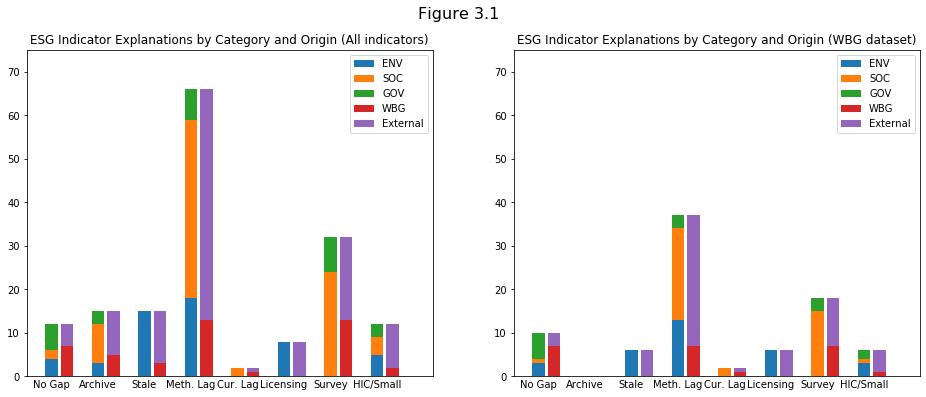

In [14]:
# plots
def every_other(n,odd=True,fill=0):
    z = list(chain.from_iterable(list(map(lambda x: [fill,x,fill], n))))
    if odd:
        z = z[1:]
        z.append(fill)
    
    return z

def plot_esg(limit):
    esg2 = esg[(esg['wbgv1']==1) | (not limit)]
    sector_data = esg2.groupby(['sector']).sum()[explans]
    origin_data = esg2.groupby(['domain']).sum()[explans]
    sx = range(0,len(sector_data.columns)*3)

    pEnv = plt.bar(sx, every_other(sector_data.loc['ENV']))
    pSoc = plt.bar(sx, every_other(sector_data.loc['SOC']),bottom=every_other(sector_data.loc['ENV']))
    pGov = plt.bar(sx, every_other(sector_data.loc['GOV']),bottom=every_other(sector_data.loc['ENV']+sector_data.loc['SOC']))
    pWbg = plt.bar(sx, every_other(origin_data.loc['WBG'],False))
    pExt = plt.bar(sx, every_other(origin_data.loc['EXTERNAL'],False),bottom=every_other(origin_data.loc['WBG'],False))
    plt.xticks(sx, labels=every_other(['No Gap', 'Archive', 'Stale', 'Meth. Lag', 'Cur. Lag', 'Licensing', 'Survey', 'HIC/Small'],fill=None))
    plt.tick_params(axis='x', length=0)
    plt.ylim(0, 75)

    plt.legend((pEnv, pSoc, pGov,pWbg, pExt), ('ENV', 'SOC', 'GOV', 'WBG', 'External'))
    plt.title('ESG Indicator Explanations by Category and Origin ({})'.format('WBG dataset' if limit else 'All indicators'))

plt.figure(figsize=(16,6)).suptitle('Figure 3.1', fontsize=16)
plt.subplot(1, 2, 1)
plot_esg(False)
plt.subplot(1, 2, 2)
plot_esg(True)

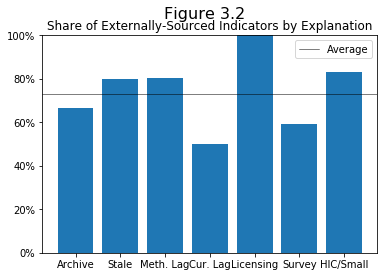

In [15]:
import matplotlib.ticker as ticker

def plot_shares(ax, columns, data, ref):
    
    ax.bar(range(0,len(columns)), data)
    plt.xticks(range(0,len(columns)), ['Archive', 'Stale', 'Meth. Lag', 'Cur. Lag', 'Licensing', 'Survey', 'HIC/Small'])
    plt.ylim(0,1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    if ref:
        ax.axhline(ref, 0, len(columns), lw=0.5, color='black',label='Average')
        ax.legend()

esg2 = esg.groupby('domain').sum()[expl_a_g]

for i in esg2.columns:
    esg2[i] = esg2[i] / esg2[i].sum()

plt.figure().suptitle('Figure 3.2', fontsize=16)
plot_shares(plt.subplot(), esg2.columns, esg2.loc['EXTERNAL'], work.loc['EXTERNAL', 'Total'])
plt.title('Share of Externally-Sourced Indicators by Explanation')
plt.show()

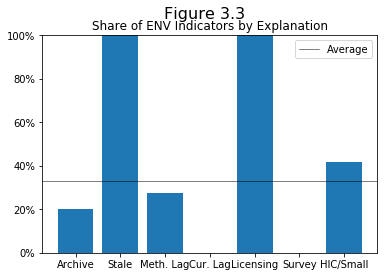

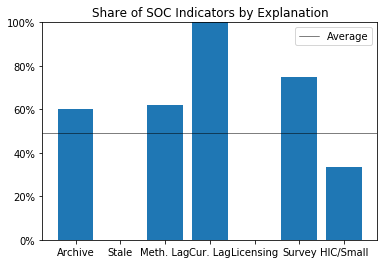

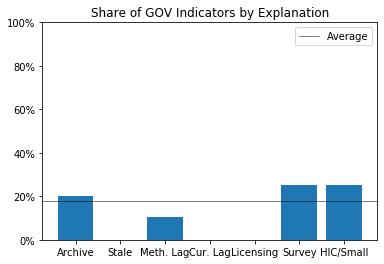

In [16]:

esg2 = esg.groupby('sector').sum().reindex(['ENV', 'SOC', 'GOV'])[expl_a_g]

for i in esg2.columns:
    esg2[i] = esg2[i] / esg2[i].sum()

plt.figure().suptitle('Figure 3.3', fontsize=16)
n = 1
for c in esg2.index:
    
    plot_shares(plt.subplot(), esg2.columns, esg2.loc[c], work.loc['Total', c])
    plt.title('Share of {} Indicators by Explanation'.format(c))
    plt.show()
    n = n+1

# hmm, this could definitely be better. Perhaps combine into one chart similar to Fig. 3.1?


## Appendices

In [17]:
pd.options.display.max_rows = 100
esg[esg.no_gap].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
2,AG.LND.TOTL.K2,Land area (sq. km),ENV,0
32,EN.MAM.THRD.NO,"Mammal species, threatened",ENV,1
33,EN.POP.DNST,Population density (people per sq. km of land ...,ENV,1
40,ER.PTD.TOTL.ZS,Terrestrial and marine protected areas (% of t...,ENV,1
5,CC.EST,Control of Corruption: Estimate,GOV,1
45,GE.EST,Government Effectiveness: Estimate,GOV,1
77,PV.EST,Political Stability and Absence of Violence/Te...,GOV,1
78,RL.EST,Rule of Law: Estimate,GOV,1
79,RQ.EST,Regulatory Quality: Estimate,GOV,1
132,VA.EST,Voice and Accountability: Estimate,GOV,1


In [18]:
esg[esg.expl_a].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
24,EN.ATM.PM10.MC.M3,"PM10, country level (micrograms per cubic meter)",ENV,0
36,ER.BDV.TOTL.XQ,GEF benefits index for biodiversity (0 = no bi...,ENV,0
74,NY.GEN.DNGY.GD.ZS,Genuine savings: energy depletion (% of GDP),ENV,0
44,GC.BAL.CASH.CD,"Fiscal balance, cash surplus/deficit (current ...",GOV,0
47,IBP.OBI.XQ,Open Budget Index Overall Country Score,GOV,0
130,TX.CONC.IND.XQ,Export product concentration index,GOV,0
42,GB.BAL.OVRX.CN,"Overall surplus/deficit, excluding current gra...",SOC,0
49,IC.ELC.OUTG.HR,Average duration of power outages (hours),SOC,0
58,IT.MLT.MAIN.P3,"Telephone mainlines (per 1,000 people)",SOC,0
60,IT.NET.USER.P3,"Internet users (per 1,000 people)",SOC,0


In [19]:
esg[esg.expl_b].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
18,EN.ATM.CO2E.KT,CO2 emissions (kt),ENV,0
19,EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita),ENV,1
20,EN.ATM.GHGT.KT.CE,Total greenhouse gas emissions (kt of CO2 equi...,ENV,0
21,EN.ATM.METH.PC,Methane emissions (metric tons of CO2 equivale...,ENV,1
22,EN.ATM.NOXE.KT.CE,Nitrous oxide emissions (thousand metric tons ...,ENV,0
23,EN.ATM.NOXE.PC,Nitrous oxide emissions (metric tons of CO2 eq...,ENV,1
27,EN.CLC.GHGR.MT.CE,GHG net emissions/removals by LUCF (Mt of CO2 ...,ENV,1
29,EN.CLC.MDAT.ZS,"Droughts, floods, extreme temperatures (% of p...",ENV,1
34,EN.POP.EL5M.ZS,Population living in areas where elevation is ...,ENV,0
37,ER.H2O.FWTL.ZS,"Annual freshwater withdrawals, total (% of int...",ENV,1


In [20]:
esg[esg.expl_c].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
0,AG.LND.AGRI.ZS,Agricultural land (% of land area),ENV,1
71,NY.ADJ.DPEM.GN.ZS,Adjusted savings: particulate emission damage ...,ENV,0
70,NY.ADJ.DNGY.GN.ZS,Adjusted savings: energy depletion (% of GNI),ENV,0
69,NY.ADJ.DMIN.CD,Adjusted savings: mineral depletion (current US$),ENV,0
68,NY.ADJ.DFOR.GN.ZS,Adjusted savings: net forest depletion (% of GNI),ENV,1
25,EN.ATM.PM25.MC.M3,"PM2.5 air pollution, mean annual exposure (mic...",ENV,1
17,EG.USE.PCAP.KG.OE,Energy use (kg of oil equivalent per capita),ENV,1
16,EG.USE.COMM.FO.ZS,Fossil fuel energy consumption (% of total),ENV,1
15,EG.IMP.CONS.ZS,"Energy imports, net (% of energy use)",ENV,1
14,EG.GDP.PUSE.KO.PP,GDP per unit of energy use (PPP $ per kg of oi...,ENV,0


In [21]:
esg[esg.expl_d].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
64,NV.AGR.TOTL.ZS,"Agriculture, forestry, and fishing, value adde...",SOC,1
89,SG.GEN.PARL.ZS,Proportion of seats held by women in national ...,SOC,1


In [22]:
esg[esg.expl_e].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
8,EG.EGY.PRIM.PP.KD,Energy intensity level of primary energy (MJ/$...,ENV,1
10,EG.ELC.COAL.ZS,Electricity production from coal sources (% of...,ENV,1
11,EG.ELC.NUCL.ZS,Electricity production from nuclear sources (%...,ENV,0
12,EG.ELC.RNEW.ZS,Renewable electricity output (% of total elect...,ENV,1
14,EG.GDP.PUSE.KO.PP,GDP per unit of energy use (PPP $ per kg of oi...,ENV,0
15,EG.IMP.CONS.ZS,"Energy imports, net (% of energy use)",ENV,1
16,EG.USE.COMM.FO.ZS,Fossil fuel energy consumption (% of total),ENV,1
17,EG.USE.PCAP.KG.OE,Energy use (kg of oil equivalent per capita),ENV,1


In [23]:
esg[esg.expl_f].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
133,WBL,Retirement Age,GOV,0
35,ENF.CONT.COEN.COST.ZS,Cost to enforce a contract (% of claim),GOV,0
48,IC.BUS.EASE.XQ,Ease of doing business index (1=most business-...,GOV,1
50,IC.FRM.OUTG.ZS,Value lost due to electrical outages (% of sal...,GOV,0
51,IC.LGL.CRED.XQ,Strength of legal rights index (0=weak to 12=s...,GOV,1
52,IC.REG.DURS,Time required to start a business (days),GOV,0
53,IC.TAX.TOTL.CP.ZS,Total tax rate (% of commercial profits),GOV,0
129,SP.UWT.TFRT,Unmet need for contraception (% of married wom...,GOV,1
112,SL.TLF.0714.ZS,"Children in employment, total (% of children a...",SOC,1
113,SL.TLF.ACTI.ZS,"Labor force participation rate, total (% of to...",SOC,1


In [24]:
esg[esg.expl_g].sort_values(['sector'])[['cetsid','input_name','sector','wbgv1']]

,cetsid,input_name,sector,wbgv1
10,EG.ELC.COAL.ZS,Electricity production from coal sources (% of...,ENV,1
11,EG.ELC.NUCL.ZS,Electricity production from nuclear sources (%...,ENV,0
15,EG.IMP.CONS.ZS,"Energy imports, net (% of energy use)",ENV,1
71,NY.ADJ.DPEM.GN.ZS,Adjusted savings: particulate emission damage ...,ENV,0
72,NY.ADJ.DRES.GN.ZS,Adjusted savings: natural resources depletion ...,ENV,1
46,GFDD.DM.06,Outstanding international public debt securiti...,GOV,0
56,IP.PAT.RESD,"Patent applications, residents",GOV,1
129,SP.UWT.TFRT,Unmet need for contraception (% of married wom...,GOV,1
6,DT.ODA.ODAT.CD,Net official development assistance received (...,SOC,0
62,MS.MIL.XPND.GD.ZS,Military expenditure (% of GDP),SOC,0
